Run simulations for ectopic polysome productions

In [1]:
%autosave 5

Autosaving every 5 seconds


In [2]:
from jax import config

config.update("jax_enable_x64", True)

import numpy as onp
import matplotlib.pyplot as plt
import jax.numpy as np
from jax import lax
import os, argparse, pickle
from tqdm import tqdm


plt.rcParams.update(
    {
        "mathtext.fontset": "stix",
        "font.family": "STIXGeneral",
        "legend.fontsize": 14,  # this is the font size in legends
        "xtick.labelsize": 14,  # this and next are the font of ticks
        "ytick.labelsize": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 18,  # this is the fonx of axes labels
        "savefig.format": "pdf",  # how figures should be saved
        "legend.edgecolor": "0.0",
        "legend.framealpha": 1.0,
    }
)

linewidth = 2
plasmamap = plt.get_cmap("plasma")

In [5]:
data_length = onp.load("sander_initial_length.npz", allow_pickle=True)

data_growth_rate = data_length["growth_rate"]
data_initial_length = data_length["initial_length"]
fitres_length_growth = onp.polyfit(data_growth_rate, onp.log(data_initial_length), 1)
l_init_fun = lambda gr: onp.exp(fitres_length_growth[1] + fitres_length_growth[0] * gr)

In [6]:
gamma = 0.25  # slow growth
T = onp.log(2) / gamma * 60 * 60
l_init = l_init_fun(gamma)
k10 = 0.002
kn1 = 0.003  # corresponding to a half-life of ~ 5 mins

gamma_seconds = gamma / 60 / 60
k1 = k10 * (1 + gamma_seconds / kn1)

gamma, T, l_init

(0.25, 9981.319400063212, 2.187608980749756)

In [7]:
parser = argparse.ArgumentParser(description="MavQ_4species_V1_1")
parser.add_argument("--L", type=int, default=1, help="rescaled length")
parser.add_argument("--N", type=int, default=128)

parser.add_argument("--k1", type=float, default=k1, help="k1")
parser.add_argument("--kn1", type=float, default=kn1, help="kn1")

parser.add_argument("--chip", type=float, default=0.2)
parser.add_argument("--chin", type=float, default=0.4)
parser.add_argument("--chinp", type=float, default=1.2)

parser.add_argument("--Vn", type=float, default=10.0, help="nucleoid volume")
parser.add_argument("--Vp", type=float, default=5.0, help="polysome volume")

parser.add_argument(
    "--lmda", type=float, default=0.03, help="interface width, in micron"
)
parser.add_argument(
    "--Dn",
    type=float,
    default=5e-3,  # this is the value used for sander  data
    help="diffusion coefficient of nucleoid, in micron^2/s",
)
parser.add_argument(
    "--Dp",
    type=float,
    default=0.023,  # this is the value used for sander data
    help="diffusion coefficient of polysomes, in micron^2/s",
)

parser.add_argument("--T", type=float, default=T, help="total elongation time (in s)")
parser.add_argument(
    "--T-init", type=float, default=4000, help="total initialization time (in s)"
)
parser.add_argument("--dt", type=float, default=0.01, help="time step (in s)")
parser.add_argument(
    "--l-center", type=float, default=0.15, help="initial nucleoid length "
)
parser.add_argument(
    "--phi-center-n", type=float, default=0.6, help="initial nucleoid concentration"
)
parser.add_argument(
    "--phi-center-p", type=float, default=0.02, help="initial polysome concentration"
)
parser.add_argument(
    "--phi-boundary-n", type=float, default=0.02, help="boundary nucleoid concentration"
)
parser.add_argument(
    "--phi-boundary-p", type=float, default=0.85, help="boundary polysome concentration"
)
parser.add_argument(
    "--init-name",
    type=str,
    default=None,
    help="file name for the initial condition",
)
parser.add_argument("--l-init", type=float, default=l_init, help="initial cell length ")
parser.add_argument(
    "--gamma", type=float, default=gamma, help="growth (dilution) rate "
)

parser.add_argument(
    "--l-decay", type=float, default=2.0 / 16, help="decay length of degradation rate"
)
flags = parser.parse_args("")

In [8]:
############################################################################################################
chip, chin, chinp = flags.chip, flags.chin, flags.chinp
lmda = flags.lmda
Dn, Dp = flags.Dn * flags.Vn, flags.Dp * flags.Vp
v_molecule = np.array([flags.Vp, flags.Vn])

# total cell length
l_init = flags.l_init
# l_final = flags.l_final
T = flags.T
gamma = onp.log(2) / T
l_t_fun = lambda t: l_init * onp.exp(gamma * t)

############################################################################################################
# x_list = np.linspace(-flags.L, flags.L, flags.N)
dx = 2 * flags.L / flags.N
x_list = np.arange(-flags.L, flags.L, dx) + dx / 2
dx = x_list[1] - x_list[0]
kx_list = 2 * np.pi * np.fft.fftfreq(flags.N, d=dx)
kx = kx_list
kxj = kx_list * 1j
k2 = kx_list**2
k4 = kx_list**4


phitol = 1e-6


def calc_mu_fft(
    phi,
    phitfft,
    chip=flags.chip,
    chin=flags.chin,
    chinp=flags.chinp,
    lmda2=flags.lmda**2,
):
    mu_entropy = (
        np.log(np.minimum(np.maximum(phi, phitol), 1 - phitol))
        / v_molecule[:, np.newaxis]
    )
    mu_entropy_solvent = np.log(
        np.minimum(np.maximum(1 - phi.sum(axis=0), phitol), 1 - phitol)
    )
    mu_p_fft = (
        np.fft.fft(mu_entropy[0] - mu_entropy_solvent)
        + chip * (1 - k2 * lmda2) * (-2 * phitfft[0] - phitfft[1])
        + (chinp - chin) * (1 - k2 * lmda2) * phitfft[1]
    )
    mu_n_fft = (
        np.fft.fft(mu_entropy[1] - mu_entropy_solvent)
        + chin * (1 - k2 * lmda2) * (-2 * phitfft[1] - phitfft[0])
        + (chinp - chip) * (1 - k2 * lmda2) * phitfft[0]
    )
    return np.array([mu_p_fft, mu_n_fft])


# artificial term to stabilize the UV
Astable = kx**4 * lmda**2 / l_init**2 * max([chip, chin, chinp]) * max([Dp, Dn]) / 2


# semi-implicit + predictor-corrector iteration
def calc_step(
    phi,
    phitfft,
    dt,
    pcg_itr=4,
    Dp=flags.Dp,
    Dn=flags.Dn,
    k1=flags.k1,
    kn1=flags.kn1,
    lmda2=flags.lmda**2,
):
    mu_fft = calc_mu_fft(phi, phitfft, lmda2=lmda2)
    dphi_fft_diffusion = kxj * np.fft.fft(
        np.array([Dp, Dn])[:, np.newaxis] * phi * np.fft.ifft(kxj * mu_fft).real
    )
    dphi_fft_reaction = np.array(
        [k1 * phitfft[1] - np.fft.fft(kn1 * phi[0]), np.zeros_like(phitfft[0])]
    )
    dphi_predictor = dphi_fft_diffusion + dphi_fft_reaction + Astable * phitfft
    phitfft_predictor = (phitfft + dt * (dphi_predictor)) / (1 + dt * Astable)
    phit_predictor = np.fft.ifft(phitfft_predictor).real
    phit_predictor = phit_predictor.at[:, flags.N // 2 :].set(
        phit_predictor[:, flags.N // 2 - 1 :: -1]
    )
    for itr in range(pcg_itr):
        mu_fft_corrector = calc_mu_fft(phit_predictor, phitfft_predictor, lmda2=lmda2)
        dphi_fft_diffusion_corrector = kxj * np.fft.fft(
            np.array([Dp, Dn])[:, np.newaxis]
            * phit_predictor
            * np.fft.ifft(kxj * mu_fft_corrector).real
        )
        dphi_fft_reaction_corrector = np.array(
            [
                k1 * phitfft_predictor[1] - np.fft.fft(kn1 * phit_predictor[0]),
                np.zeros_like(phitfft[0]),
            ]
        )
        dphi_corrector = (
            dphi_fft_diffusion_corrector
            + dphi_fft_reaction_corrector
            + Astable * phitfft_predictor
        )
        phitfft_predictor = (phitfft + dt * (dphi_predictor + dphi_corrector) / 2) / (
            1 + dt * Astable
        )
        phit_predictor = np.fft.ifft(phitfft_predictor).real
        phit_predictor = phit_predictor.at[:, flags.N // 2 :].set(
            phit_predictor[:, flags.N // 2 - 1 :: -1]
        )

    phi = phit_predictor
    # volume cannot be negative
    phi = np.maximum(phi, phitol)
    return phi, np.fft.fft(phi)


def initialize_phi(phi_center, phi_boundary, center_length, interface_width):
    phi = onp.ones((2, flags.N)) * phi_boundary[:, np.newaxis]
    phi = (
        phi
        + (
            onp.tanh(
                (center_length - onp.abs((x_list + flags.L / 2))) / interface_width
            )
            + 1
        )
        / 2
        * (phi_center - phi_boundary)[:, np.newaxis]
    )
    phi[:, flags.N // 2 :] = phi[:, flags.N // 2 - 1 :: -1]
    return phi

### Visualization

In [9]:
def plot_phi_absolute(phi, l, ylims=None, xlims=None, fig=None, ax=None, ls="-"):
    if fig is None:
        fig, ax1 = plt.subplots(figsize=(6, 4), tight_layout=True)
        ax2 = ax1.twinx()
        ax = [ax1, ax2]
    field_names = ["polysome $p$", "nucleoid $n$"]
    colors = ["tab:blue", "tab:red"]
    for i in range(2):
        ax[i].plot(
            (x_list[flags.N // 2 :] - 0.5) * l,
            phi[i][flags.N // 2 :],
            label=field_names[i],
            linewidth=linewidth,
            color=colors[i],
            linestyle=ls,
        )
        ax[i].set_ylabel(field_names[i], color=colors[i])
        if ylims is not None:
            ax[i].set_ylim(0, ylims[i])
    ax[0].set_xlabel("Cell length ($\mu m$)")
    for i in range(2):
        if xlims is not None:
            ax[i].set_xlim(xlims)
            ax[i].axvline(l / 2, color="k", linestyle="--")
            ax[i].axvline(-l / 2, color="k", linestyle="--")
        else:
            ax[i].set_xlim(-l / 2, l / 2)
    return fig, ax

<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_87526/3385557709.py:20: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_xlabel("Cell length ($\mu m$)")


In [10]:
def plot_kymograph(t_trace, phi_trace):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True, sharex=True)
    X, Y = np.meshgrid(t_trace / 60, x_list[flags.N // 2 :])
    c = ax[0].pcolormesh(
        X,
        Y,
        phi_trace[:, 0, flags.N // 2 :].T,
        cmap="Blues",
        vmin=0,
        # vmax=1,
        shading="auto",
    )
    c.set_edgecolor("face")
    plt.colorbar(
        c,
        ax=ax[0],
        fraction=0.046,
        pad=0.04,
        label="polysome $p$",
    )
    c = ax[1].pcolormesh(
        X,
        Y,
        phi_trace[:, 1, flags.N // 2 :].T,
        cmap="Reds",
        vmin=0,
        # vmax=1,
        shading="auto",
    )
    c.set_edgecolor("face")
    plt.colorbar(
        c,
        ax=ax[1],
        fraction=0.046,
        pad=0.04,
        label="nucleoid $n$",
    )
    ax[1].set_xlabel("$t$ (min)")
    ax[0].set_ylabel("Relative cell length $x/L$")
    ax[1].set_ylabel("Relative cell length $x/L$")
    return fig, ax

In [11]:
def plot_kymograph_absolute(t_trace, phi_trace, l_trace):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True, sharex=True)
    X, Y = np.meshgrid(t_trace / 60, x_list[flags.N // 2 :])
    Y = (Y - 0.5) * l_trace
    c = ax[0].pcolormesh(
        X,
        Y,
        phi_trace[:, 0, flags.N // 2 :].T,
        cmap="Blues",
        vmin=0,
        # vmax=1,
        shading="auto",
    )
    c.set_edgecolor("face")
    plt.colorbar(
        c,
        ax=ax[0],
        fraction=0.046,
        pad=0.04,
        label="polysome $p$",
    )
    c = ax[1].pcolormesh(
        X,
        Y,
        phi_trace[:, 1, flags.N // 2 :].T,
        cmap="Reds",
        vmin=0,
        # vmax=1,
        shading="auto",
    )
    c.set_edgecolor("face")
    plt.colorbar(
        c,
        ax=ax[1],
        fraction=0.046,
        pad=0.04,
        label="nucleoid $n$",
    )
    ax[1].set_xlabel("$t$ (min)")
    ax[0].set_ylabel("Posotion $x$ ($\mu m$)")
    ax[1].set_ylabel("Position $x$ ($\mu m$)")
    return fig, ax

<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\m'
/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_87526/698841180.py:40: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_ylabel("Posotion $x$ ($\mu m$)")
/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_87526/698841180.py:41: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_ylabel("Position $x$ ($\mu m$)")


## Initialization and a normal cell cycle

In [12]:
ouptput_section = "data_ectopic/"
os.system(f"mkdir -p {ouptput_section}")

0

In [13]:
l_center = flags.l_center
phit_init = initialize_phi(
    onp.array([flags.phi_center_p, flags.phi_center_n]),
    onp.array([flags.phi_boundary_p, flags.phi_boundary_n]),
    l_center,
    flags.lmda,
)

dt = flags.dt
N_steps = int(flags.T_init / dt)
t_trace = np.arange(N_steps) * dt


def sub_run(vals, i):
    vals = calc_step(
        vals[0],
        vals[1],
        dt,
        Dp=Dp / l_init ** (2),
        Dn=Dn / l_init ** (2),
        k1=flags.k1,
        kn1=flags.kn1 + gamma,
        lmda2=flags.lmda ** (2) / l_init ** (2),
    )
    return vals, vals[0]


(phi_init_ss, phi_init_ss_fft), phi_init_trace = lax.scan(
    sub_run, (phit_init.copy(), np.fft.fft(phit_init)), np.arange(N_steps), unroll=4
)

# save the simulation results
steps_skip = min(200, N_steps // 200)

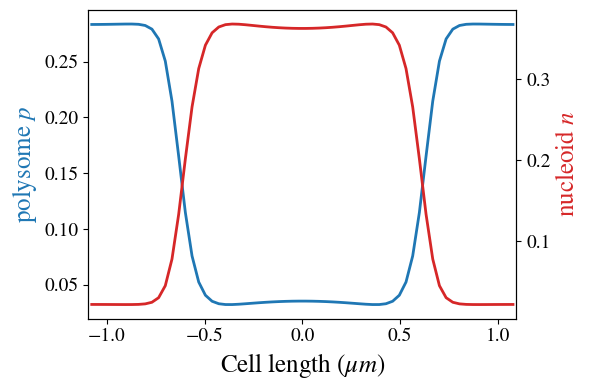

In [14]:
fig, ax = plot_phi_absolute(phi_init_trace[-1], l_init, ls="-")
fig.savefig(f"{ouptput_section}/phi_init.pdf")

In [15]:
np.savez(
    ouptput_section + f"/phi_init.npz",
    phi_trace=phi_init_trace[::steps_skip],
    t_trace=t_trace[::steps_skip],
    l_init=l_init,
)

## Ectopic polysome production at the pole

In [28]:
# plasmid localized to the pole


def calc_step_plasmid_pole(
    phi,
    phitfft,
    dt,
    pcg_itr=4,
    Dp=flags.Dp,
    Dn=flags.Dn,
    k1=flags.k1,
    k2=0.0,  # production rate due to plasmid
    x2=0.0,  # range of the plasmid, in relative units
    kn1=flags.kn1,
    lmda2=flags.lmda**2,
):
    plamid_production = k2 * np.heaviside(x2 - np.abs(x_list), 0.5)
    plamid_production_fft = np.fft.fft(plamid_production)
    mu_fft = calc_mu_fft(phi, phitfft, lmda2=lmda2)
    dphi_fft_diffusion = kxj * np.fft.fft(
        np.array([Dp, Dn])[:, np.newaxis] * phi * np.fft.ifft(kxj * mu_fft).real
    )
    dphi_fft_reaction = np.array(
        [
            k1 * phitfft[1] + plamid_production_fft - np.fft.fft(kn1 * phi[0]),
            np.zeros_like(phitfft[0]),
        ]
    )
    dphi_predictor = dphi_fft_diffusion + dphi_fft_reaction + Astable * phitfft
    phitfft_predictor = (phitfft + dt * (dphi_predictor)) / (1 + dt * Astable)
    phit_predictor = np.fft.ifft(phitfft_predictor).real
    phit_predictor = phit_predictor.at[:, flags.N // 2 :].set(
        phit_predictor[:, flags.N // 2 - 1 :: -1]
    )
    for itr in range(pcg_itr):
        mu_fft_corrector = calc_mu_fft(phit_predictor, phitfft_predictor, lmda2=lmda2)
        dphi_fft_diffusion_corrector = kxj * np.fft.fft(
            np.array([Dp, Dn])[:, np.newaxis]
            * phit_predictor
            * np.fft.ifft(kxj * mu_fft_corrector).real
        )
        dphi_fft_reaction_corrector = np.array(
            [
                k1 * phitfft_predictor[1]
                + plamid_production_fft
                - np.fft.fft(kn1 * phit_predictor[0]),
                np.zeros_like(phitfft[0]),
            ]
        )
        dphi_corrector = (
            dphi_fft_diffusion_corrector
            + dphi_fft_reaction_corrector
            + Astable * phitfft_predictor
        )
        phitfft_predictor = (phitfft + dt * (dphi_predictor + dphi_corrector) / 2) / (
            1 + dt * Astable
        )
        phit_predictor = np.fft.ifft(phitfft_predictor).real
        phit_predictor = phit_predictor.at[:, flags.N // 2 :].set(
            phit_predictor[:, flags.N // 2 - 1 :: -1]
        )

    phi = phit_predictor
    # volume cannot be negative
    phi = np.maximum(phi, phitol)
    return phi, np.fft.fft(phi)

In [29]:
k1_plasmid = flags.k1 * 0.5
k2_plasmid = flags.k1 * 0.8
x2_plasmid = 0.8

In [30]:
i = 0
x2 = x2_plasmid / l_init
plamsid_production = k1_plasmid * np.heaviside(x2 - np.abs(x_list), 0.5)
nucleoid_production = k1 * phi_init_ss[1]
print("percentage of plasmid production at the pole")
print(plamsid_production.sum() / (plamsid_production.sum() + nucleoid_production.sum()))

percentage of plasmid production at the pole
0.46061108716496757


In [31]:
## elongation

dt = flags.dt
N_steps = int(T / dt)

t_trace = np.arange(N_steps) * dt
l_trace = np.array(l_t_fun(t_trace))


def sub_run(vals, i):
    vals = calc_step_plasmid_pole(
        vals[0],
        vals[1],
        dt,
        Dp=Dp / l_trace[i] ** 2,
        Dn=Dn / l_trace[i] ** 2,
        k1=k1_plasmid,
        k2=k2_plasmid,
        x2=x2_plasmid / l_trace[i],
        kn1=flags.kn1 + gamma,
        lmda2=flags.lmda**2 / l_trace[i] ** 2,
    )
    return vals, vals[0]


(phit, phit_fft), phi_trace_plasmid = lax.scan(
    sub_run, (phi_init_ss, phi_init_ss_fft), np.arange(N_steps), unroll=4
)

In [32]:
np.savez(
    ouptput_section + f"/phi_plasmid_pole.npz",
    phi_trace=phi_trace_plasmid[::steps_skip],
    t_trace=t_trace[::steps_skip],
    l_trace=l_trace[::steps_skip],
)

Plot Kymograph in absolute units

/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_87526/698841180.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax[0].pcolormesh(
/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_87526/698841180.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax[1].pcolormesh(


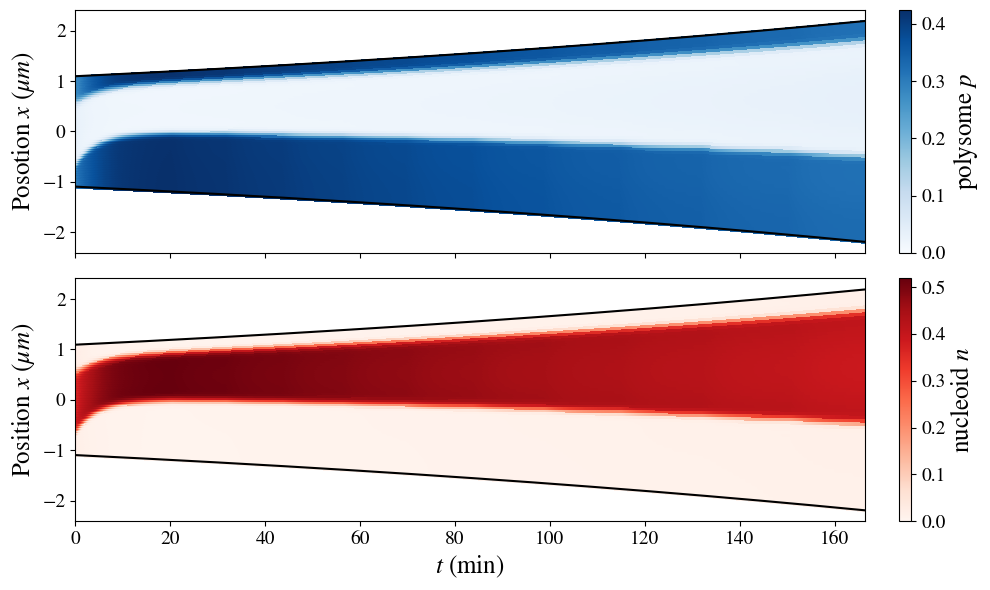

In [33]:
fig, ax = plot_kymograph_absolute(
    t_trace[::steps_skip], phi_trace_plasmid[::steps_skip], l_trace[::steps_skip]
)
for i in range(2):
    ax[i].plot(t_trace / 60, l_trace / 2, color="k", linestyle="-")
    ax[i].plot(t_trace / 60, -l_trace / 2, color="k", linestyle="-")
ax[1].set_xlim(0, t_trace[-1] / 60)
fig.savefig(f"{ouptput_section}/phi_plasmid_pole_kymograph_absolute.png", dpi=300)

## Ectopic polysome production between sister nucleoids

In [21]:
def calc_step_plasmid_center(
    phi,
    phitfft,
    dt,
    pcg_itr=4,
    Dp=flags.Dp,
    Dn=flags.Dn,
    k1=flags.k1,
    k2=0.0,  # production rate due to plasmid
    x2=0.0,  # range of the plasmid, in relative units
    kn1=flags.kn1,
    lmda2=flags.lmda**2,
):
    plamid_production = k2 * np.heaviside(x2 - np.abs(np.abs(x_list) - 0.5), 0.5)
    plamid_production_fft = np.fft.fft(plamid_production)
    mu_fft = calc_mu_fft(phi, phitfft, lmda2=lmda2)
    dphi_fft_diffusion = kxj * np.fft.fft(
        np.array([Dp, Dn])[:, np.newaxis] * phi * np.fft.ifft(kxj * mu_fft).real
    )
    dphi_fft_reaction = np.array(
        [
            k1 * phitfft[1] + plamid_production_fft - np.fft.fft(kn1 * phi[0]),
            np.zeros_like(phitfft[0]),
        ]
    )
    dphi_predictor = dphi_fft_diffusion + dphi_fft_reaction + Astable * phitfft
    phitfft_predictor = (phitfft + dt * (dphi_predictor)) / (1 + dt * Astable)
    phit_predictor = np.fft.ifft(phitfft_predictor).real
    phit_predictor = phit_predictor.at[:, flags.N // 2 :].set(
        phit_predictor[:, flags.N // 2 - 1 :: -1]
    )
    for itr in range(pcg_itr):
        mu_fft_corrector = calc_mu_fft(phit_predictor, phitfft_predictor, lmda2=lmda2)
        dphi_fft_diffusion_corrector = kxj * np.fft.fft(
            np.array([Dp, Dn])[:, np.newaxis]
            * phit_predictor
            * np.fft.ifft(kxj * mu_fft_corrector).real
        )
        dphi_fft_reaction_corrector = np.array(
            [
                k1 * phitfft_predictor[1]
                + plamid_production_fft
                - np.fft.fft(kn1 * phit_predictor[0]),
                np.zeros_like(phitfft[0]),
            ]
        )
        dphi_corrector = (
            dphi_fft_diffusion_corrector
            + dphi_fft_reaction_corrector
            + Astable * phitfft_predictor
        )
        phitfft_predictor = (phitfft + dt * (dphi_predictor + dphi_corrector) / 2) / (
            1 + dt * Astable
        )
        phit_predictor = np.fft.ifft(phitfft_predictor).real
        phit_predictor = phit_predictor.at[:, flags.N // 2 :].set(
            phit_predictor[:, flags.N // 2 - 1 :: -1]
        )

    phi = phit_predictor
    # volume cannot be negative
    phi = np.maximum(phi, phitol)
    return phi, np.fft.fft(phi)

In [22]:
k1_plasmid = flags.k1 * 0.5
k2_plasmid = flags.k1 * 0.5
x2_plasmid = 0.4

In [24]:
i = 0
x2 = x2_plasmid / l_init
plamsid_production = k1_plasmid * np.heaviside(x2 - np.abs(np.abs(x_list) - 0.5), 0.5)
nucleoid_production = k1 * phi_init_ss[1]
print("percentage of plasmid production at the center")
print(plamsid_production.sum() / (plamsid_production.sum() + nucleoid_production.sum()))

percentage of plasmid production at the center
0.47120111453563557


In [25]:
## elongation

dt = flags.dt
N_steps = int(T / dt)

t_trace = np.arange(N_steps) * dt
l_trace = np.array(l_t_fun(t_trace))


def sub_run(vals, i):
    vals = calc_step_plasmid_center(
        vals[0],
        vals[1],
        dt,
        Dp=Dp / l_trace[i] ** 2,
        Dn=Dn / l_trace[i] ** 2,
        k1=k1_plasmid,
        k2=k2_plasmid,
        x2=x2_plasmid / l_trace[i],
        kn1=flags.kn1 + gamma,
        lmda2=flags.lmda**2 / l_trace[i] ** 2,
    )
    return vals, vals[0]


(phit, phit_fft), phi_trace_plasmid_center = lax.scan(
    sub_run, (phi_init_ss, phi_init_ss_fft), np.arange(N_steps), unroll=4
)

In [26]:
np.savez(
    ouptput_section + f"/phi_plasmid_center.npz",
    phi_trace=phi_trace_plasmid_center[::steps_skip],
    t_trace=t_trace[::steps_skip],
    l_trace=l_trace[::steps_skip],
)

Plot Kymograph in absolute units

/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_87526/698841180.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax[0].pcolormesh(
/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_87526/698841180.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax[1].pcolormesh(


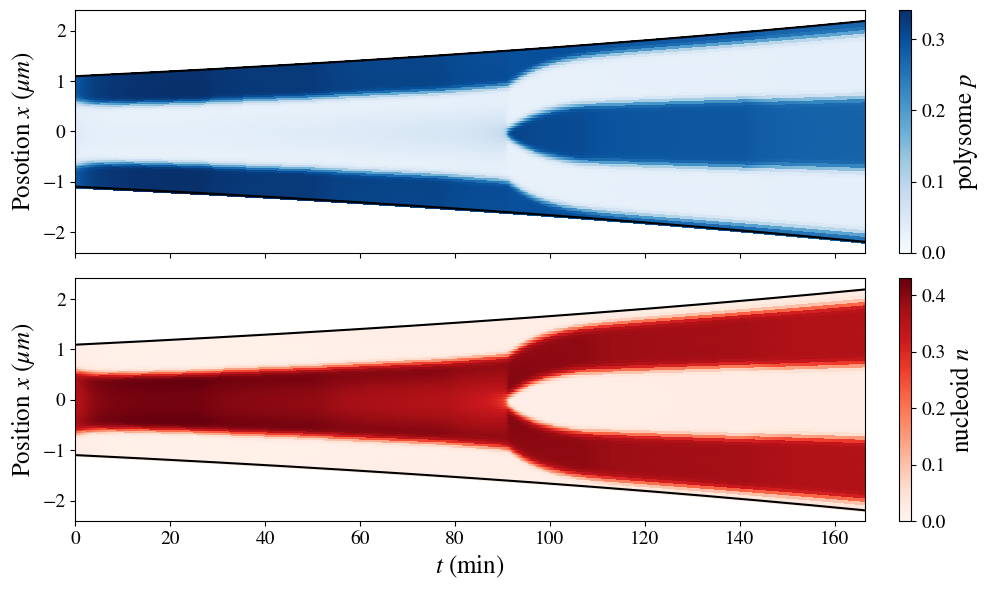

In [27]:
fig, ax = plot_kymograph_absolute(
    t_trace[::steps_skip], phi_trace_plasmid_center[::steps_skip], l_trace[::steps_skip]
)
for i in range(2):
    ax[i].plot(t_trace / 60, l_trace / 2, color="k", linestyle="-")
    ax[i].plot(t_trace / 60, -l_trace / 2, color="k", linestyle="-")
ax[1].set_xlim(0, t_trace[-1] / 60)
fig.savefig(f"{ouptput_section}/phi_plasmid_center_kymograph_absolute.png", dpi=300)